In [22]:
#Pytorch
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

#Torchvision
import torchvision
from torchvision import datasets, models, transforms, utils
  
#Pytorch
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

#Torchvision
import torchvision
from torchvision import datasets, models, transforms, utils
from torch.utils.data import Dataset, DataLoader

#Image Processing
import matplotlib.pyplot as plt
from skimage import io, transform, color
import PIL
from PIL import Image

#Others
import sklearn.metrics
from sklearn.metrics import *
import numpy as np
import pandas as pd
import cv2
import time
import os
import copy
from model_summary import *
import pretrainedmodels
import tqdm
from tqdm import tqdm_notebook as tqdm
import warnings
warnings.filterwarnings("ignore")



class dataset(Dataset):

    def __init__(self, csv_file, root_dir, transform=None):

        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.mask_dir = self.root_dir.replace('CBIS-DDSM_classification','masks')
        self.bmask_dir = self.root_dir.replace('CBIS-DDSM_classification','breast_mask')
        
    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,self.data_frame.iloc[idx]['name'])
        image = Image.open(img_name)

        label = self.data_frame.iloc[idx]['category']

        mask_name = os.path.join(self.mask_dir,self.data_frame.iloc[idx]['name'].replace('.j','_mask.j'))
        mask = io.imread(mask_name)
        mask = np.array([mask,mask,mask]).transpose((1,2,0))
        mask = Image.fromarray(mask)
        
        bmask_name = os.path.join(self.bmask_dir,self.data_frame.iloc[idx]['name'].replace('.j','_bmask.j'))
        bmask = io.imread(bmask_name)
        bmask = np.array([bmask,bmask,bmask]).transpose((1,2,0))
        bmask = Image.fromarray(bmask)
        

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask) 
            bmask = self.transform(bmask)
    
        return {'image':image,'category':label,'mask':mask, 'bmask':bmask, 'name':self.data_frame.iloc[idx]['name']}
    

def get_dataloader(data_dir, train_csv_path, image_size, img_mean, img_std, batch_size=1):

    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize(image_size),#row to column ratio should be 1.69
            #transforms.RandomHorizontalFlip(0.5),
            #transforms.CenterCrop((image_size[1],image_size[1])),
            transforms.RandomVerticalFlip(0.5),
            transforms.RandomRotation(15),
            transforms.RandomAffine(translate=(0,0.2),degrees=15,shear=15),
            transforms.ToTensor(),
            #transforms.Normalize([0.223, 0.231, 0.243], [0.266, 0.270, 0.274])
            transforms.Normalize(img_mean,img_std)
        ]),
        'valid': transforms.Compose([
            transforms.Resize(image_size),
            #transforms.CenterCrop((image_size[1],image_size[1])),
            transforms.ToTensor(),
            #transforms.Normalize([0.223, 0.231, 0.243], [0.266, 0.270, 0.274])
            transforms.Normalize(img_mean,img_std)
        ]),
        'test': transforms.Compose([
            transforms.Resize(image_size),
            #transforms.CenterCrop((image_size[1],image_size[1])),
            transforms.ToTensor(),
            #transforms.Normalize([0.223, 0.231, 0.243], [0.266, 0.270, 0.274])
            transforms.Normalize(img_mean,img_std)
        ])
    }

    image_datasets = {}
    dataloaders = {}
    dataset_sizes = {}

    for x in ['train', 'valid', 'test']:
        if x == 'test':
            bs = 1
            sh = False
        else:
            bs = batch_size
            sh = True
        image_datasets[x] = dataset(train_csv_path.replace('train',x),root_dir=data_dir,transform=data_transforms[x])
        dataloaders[x] = torch.utils.data.DataLoader(image_datasets[x], batch_size=bs,shuffle=sh, num_workers=8)    
        dataset_sizes[x] = len(image_datasets[x])

    device = torch.device("cuda:0")

    return dataloaders,dataset_sizes,image_datasets,device

def build_model():

    class mdl(nn.Module):
        def __init__(self,base_model):
            super().__init__()
            self.base = base_model 
            self.gap = nn.AdaptiveAvgPool2d((1,1))
            self.fc1 = nn.Linear(512,2)

        def forward(self, x):
            x_base = self.base(x)
            x = self.gap(x_base)
            x = x.view(x.size(0), -1)
            x = self.fc1(x)
            return x,x_base 

    v = models.vgg16_bn(pretrained=True)
    v1 = nn.Sequential(*list(v.children())[:-1])

    #r = models.resnet101(pretrained=True)
    #r1 = nn.Sequential(*list(r.children())[:-2])
    model = mdl(v1[-1][:-1])
    
    return model

def denorm_img(img_ten,img_mean,img_std):

    bz,nc,h,w = img_ten.shape
    output = []
    img_num = img_ten.numpy()
    
    for i in range(bz):
        
        img = img_ten[i].numpy().squeeze()
        
        img[0,:,:] = img[0,:,:]*img_std[0]
        img[1,:,:] = img[1,:,:]*img_std[1]
        img[2,:,:] = img[2,:,:]*img_std[2]

        img[0,:,:] = img[0,:,:] + img_mean[0]
        img[1,:,:] = img[1,:,:] + img_mean[1]
        img[2,:,:] = img[2,:,:] + img_mean[2]
        
        img = img.mean(axis=0)
        img[img>=0.2*img.max()] = 1
        img[img<0.2*img.max()] = 0
        
        output.append(img)
    
    output = np.array(output)
    return output
    
def get_IoU(pred, targs, device):

    targs = torch.Tensor(targs).to(device)
    
    #targs = torch.Tensor((targs>0)).to(device)#.float()
    #pred = (pred>0)#.float()
    return (pred*targs).sum() / ((pred+targs).sum() - (pred*targs).sum())
    
    #return (pred*targs).sum()/targs.sum()


class grad_cam():
    def __init__(self):
        
        #Initialization
        self.data_dir = '../Data/CBIS-DDSM_classification_orient/'
        self.train_csv = '../CSV/gain_train.csv'
        self.num_epochs = 50
        self.input_shape = (320,256)#(640,512) #(640,512)#(224,224)#(640,384) (640,512)
        self.batch_size = 16
        self.img_mean = [0.223, 0.231, 0.243]
        self.img_std = [0.266, 0.270, 0.274]
        
        self.exp_name = 'grad_cam_vgg_16'
        
        #Define the three models
        self.model = build_model()
        
        #Put them on the GPU
        self.model = self.model.cuda()
        
        #Get the dataloaders
        self.dataloaders,self.dataset_sizes,self.dataset,self.device = get_dataloader(self.data_dir,self.train_csv,\
                                                        self.input_shape,self.img_mean,self.img_std,self.batch_size)
        

        self.optimizer = optim.Adam(self.model.parameters(),lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
        #Define the three optimizers one for each model
        
	#self.optimizer = optim.Adam([{'params':self.model.gap.parameters()},
        #                            {'params':self.model.fc1.parameters()},
        #                            {'params':self.model.base[:6].parameters(),'lr':0.0001},
        #                            {'params':self.model.base[6:].parameters(),'lr':0.001}], lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
        
        self.loss_fn = nn.CrossEntropyLoss()
        
    def train(self):
        
        since = time.time()
        best_epoch_acc = 0.0
        best_epoch_f1 = 0.0
        
        for epoch in range(self.num_epochs):
            print('Epoch {}/{}'.format(epoch, self.num_epochs - 1),flush=True)
            print('-' * 10,flush=True)

            # Each epoch has a training and validation phase
            for phase in ['train', 'valid']:
                if phase == 'train':
                    
                    #Set the models to training mode
                    self.model.train()
                
                else:
                    #Set the models to evaluation mode
                    self.model.eval()
                    
                #Keep a track of all the three loss
                running_loss = 0.0
                
                #Metrics : predictor auc and selector iou
                running_acc = 0
                running_f1 = 0
                
                #tqdm bar
                pbar = tqdm(total=self.dataset_sizes[phase])

                # Iterate over data.
                for sampled_batch in self.dataloaders[phase]:

                    inputs = sampled_batch['image']
                    labels = sampled_batch['category']
                    mask = denorm_img(sampled_batch['mask'],self.img_mean,self.img_std)
                    bmask = torch.Tensor(denorm_img(sampled_batch['bmask'],self.img_mean,self.img_std)).to(self.device)

                    #Input needs to be float and labels long
                    inputs = inputs.float().to(self.device)
                    labels = labels.long().to(self.device)

                    # zero the parameter gradients
                    self.optimizer.zero_grad()
                
                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        
                        #import pdb;pdb.set_trace()
                        
                        outputs,_ = self.model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = self.loss_fn(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            
                            loss.backward()
                            self.optimizer.step()
                                    
                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_acc += torch.sum(preds == labels.data)
                    running_f1 += f1_score(labels.data,preds)*inputs.size(0)
                    

                    pbar.update(inputs.shape[0])
                pbar.close()

                epoch_loss = running_loss / self.dataset_sizes[phase]
                epoch_acc = running_acc.double() / self.dataset_sizes[phase]
                epoch_f1 = 1.0*running_f1 / self.dataset_sizes[phase]

                print('{} Sel_Loss: {:.4f} Acc: {:.4f} F1: {:.4f}'.format(
                    phase, epoch_loss, epoch_acc,  epoch_f1))

                # deep copy the model
                if phase == 'valid' and epoch_f1 > best_epoch_f1:
                    best_epoch_f1 = epoch_f1
                    torch.save(self.model.state_dict(),self.exp_name+'_sel.pt')
                    
        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
        print('Best Sel Loss: {:4f}'.format(best_sel_loss))

        torch.save(self.model.state_dict(),self.exp_name+'_sel_final.pt')
        
        print('Training completed finally !!!!!')
        
        
    def get_output(self,input_data):
        
        return self.selector(input_data).numpy()
        
    def test_model(self):
                
        self.selector.load_state_dict(torch.load(self.exp_name+'_sel.pt'))
        self.selector.eval()
        
        mIoU = 0
        total = 0
        mode = 'test'

        with torch.no_grad():
            for data in self.dataloaders[mode]:

                images = data['image']
                mask = data['mask']

                images = images.to(self.device)
                
                sel_prob = make_prob(self.selector(images))
                iou = get_IoU(sel_prob,mask)
                
                total += labels.size(0)
                mIoU += iou

        print("mIoU:", 1.0*mIoU/total)
        
    def test_model_auc(self):
                
        self.model.load_state_dict(torch.load(self.exp_name+'_sel.pt'))
        self.model.eval()
        
        acc = 0
        total = 0
        mode = 'test'

        predictions = []
        ground_truth = []
        
        with torch.no_grad():
            
            pbar = tqdm(total=self.dataset_sizes[mode])
            for data in self.dataloaders[mode]:

                inputs = data['image']
                labels = data['category']
                
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)
                
                output,_ = F.sigmoid(self.model(inputs))
                _,out = torch.max(output,1)
                
                predictions.append(output.cpu().numpy())
                ground_truth.append(labels.cpu().numpy())
                #ground_truth.append(labels.cpu())
                
                total += labels.size(0)
                acc += torch.sum(out==labels.data)
                pbar.update(inputs.shape[0])
            pbar.close()
                
        pred = predictions[0]
        for i in range(len(predictions)-1):
            pred = np.concatenate((pred,predictions[i+1]),axis=0)
            
        gt = ground_truth[0]
        for i in range(len(ground_truth)-1):
            gt = np.concatenate((gt,ground_truth[i+1]),axis=0)
            
        #import pdb;pdb.set_trace()
        auc = roc_auc_score(gt,pred[:,1],average='weighted')
        
        print("AUC:", auc)
        print("ACC:", acc.double()/total)
        

    def get_cam(self):
                
        self.model.load_state_dict(torch.load(self.exp_name+'_sel.pt'))
        self.model.eval()
        
        acc = 0
        total = 0
        mode = 'test'

        cm = []
        m = []
        bm = []
        
        params = list(self.model.parameters())                        
        weight_softmax = torch.squeeze(params[-2].data)
        
        iou = 0
        
        with torch.no_grad():
            
            pbar = tqdm(total=self.dataset_sizes[mode])
            for data in self.dataloaders[mode]:

                inputs = data['image']
                labels = data['category']
                mask = denorm_img(data['mask'],self.img_mean,self.img_std)
                bmask = torch.Tensor(denorm_img(data['bmask'],self.img_mean,self.img_std)).to(self.device)
                
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)
                
                output,feat = self.model(inputs)
                _,out = torch.max(output,1)      

                #Get the CAM which will the prob map
                cam = torch.matmul(weight_softmax[out[0]],feat[0].reshape(feat[0].shape[0],feat[0].shape[1]*feat[0].shape[2]))
                cam = F.relu(cam.reshape(feat[0].shape[1], feat[0].shape[2]))
                cam_img = F.interpolate(cam.unsqueeze(dim=0).unsqueeze(dim=0),(self.input_shape[0],self.input_shape[1]),mode='bilinear')             
                
                c_mean = cam_img.mean()
                c_std = cam_img.std()
                c_max = cam_img.max()
                
                cam_bin = F.relu(cam_img)
                cam_bin[cam_bin>0] = 1
                #cam_bin[cam_img<0] = 0
                
                iou += get_IoU(cam_bin,mask,self.device)
                #import pdb;pdb.set_trace()
                #print(iou)
                
                m.append(mask.squeeze())
                bm.append(bmask.squeeze())
                cm.append(cam_img.cpu().numpy().squeeze())
                                
                base_path = '../Experiments/CAM/'
                name = data['name'][0]
                
                im = name.replace('.j','_1.j')
                #import pdb;pdb.set_trace()
                inputs = inputs/inputs.max()
                cv2.imwrite(base_path+im,inputs.cpu().numpy().squeeze().transpose((1,2,0))*255)
                
                ma = name.replace('.j','_2.j')
                cv2.imwrite(base_path+ma,mask.squeeze()*255)

                pr = name.replace('.j','_3.j')
                cam_img = cam_img/cam_img.max()
                cv2.imwrite(base_path+pr,cam_img.cpu().numpy().squeeze()*255)
                
                pbar.update(inputs.shape[0])
                
            pbar.close()

        print('mIoU:',iou.double()/self.dataset_sizes[mode])

        return m,bm,cm
                
        
    def return_model(self):
        self.model.load_state_dict(torch.load(self.exp_name+'_sel.pt'))
        self.model.eval()
        mode = 'test'
        return self.model,self.dataloaders[mode]


In [23]:
gc = grad_cam()

In [24]:
m,b,c = gc.get_cam()


mIoU: tensor(0.0120, device='cuda:0', dtype=torch.float64)


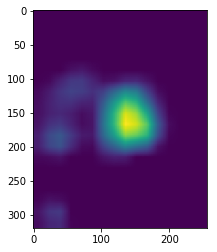

In [34]:
a = cv2.imread('../Experiments/CAM/Calc-Test_P_00038_LEFT_MLO_3.jpg',0)
plt.imshow(a)